In [1]:
# Imports and setup
import os
import sys
import io
import torch
from contextlib import redirect_stderr
from tqdm import tqdm
sys.path.append('..')

# Import custom modules
from src.data_prep import DataPreprocessor

In [2]:
def setup_directories():
    """Create necessary directories if they don't exist."""
    os.makedirs("../data/processed", exist_ok=True)
    os.makedirs("../outputs/plots", exist_ok=True)

In [3]:
def process_and_save_data():
    """Process the data and save it to disk with a progress bar."""
    print("Initializing data preprocessor...")
    preprocessor = DataPreprocessor()
    
    # Load diagnostics
    df = preprocessor.load_diagnostics()
    
    # Create datasets (without saving)
    train_loader, val_loader, _ = preprocessor.create_datasets(save_processed=False)
    
    # Process and save training data
    print("\nProcessing and saving training data...")
    os.makedirs("../data/processed/train", exist_ok=True)
    train_dataset = train_loader.dataset
    
    for idx in tqdm(range(len(train_dataset)), desc="Training data"):
        try:
            sample = train_dataset[idx]
            patient_id = train_dataset.data_df.iloc[idx]['Image']
            label = train_dataset.data_df.iloc[idx]['label']
            
            # Create class directory
            class_dir = os.path.join("../data/processed/train", str(label))
            os.makedirs(class_dir, exist_ok=True)
            
            # Save processed sample
            torch.save({
                'image': sample['image'],
                'label': label,
                'patient_id': patient_id
            }, os.path.join(class_dir, f"{patient_id}.pt"))
                
        except Exception as e:
            print(f"\nError processing training sample {idx}: {str(e)}")
            continue
    
    # Process and save validation data
    print("\nProcessing and saving validation data...")
    os.makedirs("../data/processed/val", exist_ok=True)
    val_dataset = val_loader.dataset  # Get the actual dataset from the DataLoader
    
    for idx in tqdm(range(len(val_dataset)), desc="Validation data"):
        try:
            sample = val_dataset[idx]
            patient_id = val_dataset.data_df.iloc[idx]['Image']
            label = val_dataset.data_df.iloc[idx]['label']
            
            # Create class directory
            class_dir = os.path.join("../data/processed/val", str(label))
            os.makedirs(class_dir, exist_ok=True)
            
            # Save processed sample
            torch.save({
                'image': sample['image'],
                'label': label,
                'patient_id': patient_id
            }, os.path.join(class_dir, f"{patient_id}.pt"))
                
        except Exception as e:
            print(f"\nError processing validation sample {idx}: {str(e)}")
            continue
    
    return df, train_loader, val_loader

In [4]:
def verify_processed_data():
    """Verify the processed data was saved correctly."""
    processed_dir = "../data/processed"
    if not os.path.exists(processed_dir):
        print("Error: Processed data directory not found!")
        return
    
    print("\nProcessed data verification:")
    for cls_dir in os.listdir(processed_dir):
        cls_path = os.path.join(processed_dir, cls_dir)
        if os.path.isdir(cls_path):
            print(f"- {cls_dir}: {len(os.listdir(cls_path))} samples")

Initializing data preprocessor...
Loading diagnostics from: /mnt/d/ML/Projects/Breast-Thermography/data/raw/Breast-Thermography-Raw/Diagnostics.xlsx


/mnt/d/ML/Projects/Breast-Thermography/venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/mnt/d/ML/Projects/Breast-Thermography/notebooks/../src/data_prep.py:426: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0 * strength, 50.0 * strength), p=0.1 * strength),
/mnt/d/ML/Projects/Breast-Thermography/notebooks/../src/data_prep.py:430: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


Loading diagnostics from: /mnt/d/ML/Projects/Breast-Thermography/data/raw/Breast-Thermography-Raw/Diagnostics.xlsx

Processing and saving training data...


Training data: 100%|█████████████████████████████████████████████████████████████| 95/95 [00:14<00:00,  6.47it/s]



Processing and saving validation data...


Validation data: 100%|███████████████████████████████████████████████████████████| 24/24 [00:03<00:00,  6.52it/s]



Generating data visualizations...
Plot saved to ../outputs/plots/data_distribution.png


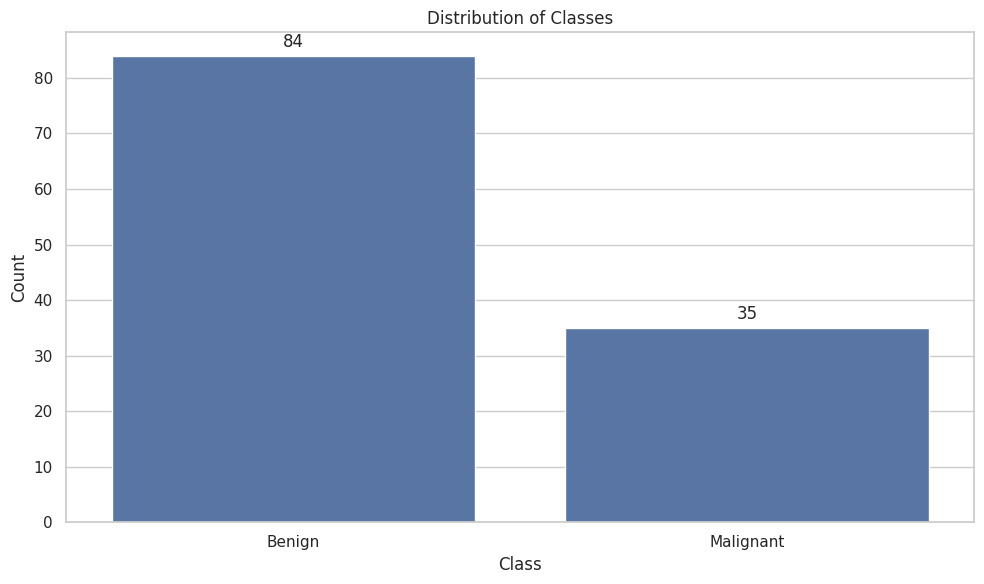


Dataset Information:
Total samples: 119
Training samples: 95
Validation samples: 24
Number of classes: 2

Class distribution:
combined_label
Benign       84
Malignant    35
Name: count, dtype: int64

Processed data verification:
- Benign: 55 samples
- Malignant: 21 samples
- train: 2 samples
- val: 2 samples

Data preprocessing complete! The processed data is ready for training.
Processed data location: /mnt/d/ML/Projects/Breast-Thermography/data/processed


In [5]:
def main():
    # Setup directories
    setup_directories()
    
    # Process and save data
    df, train_loader, val_loader = process_and_save_data()
    
    # Generate visualizations
    print("\nGenerating data visualizations...")
    preprocessor = DataPreprocessor()
    preprocessor.visualize_data_distribution(df, save_path="../outputs/plots/data_distribution.png")
    
    # Print dataset information
    print("\nDataset Information:")
    print("=" * 50)
    print(f"Total samples: {len(df)}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Number of classes: {len(df['combined_label'].unique())}")
    print("\nClass distribution:")
    print(df['combined_label'].value_counts())
    
    # Verify processed data
    verify_processed_data()
    
    print("\nData preprocessing complete! The processed data is ready for training.")
    print(f"Processed data location: {os.path.abspath('../data/processed')}")

if __name__ == "__main__":
    main()